# <center> Projet EXCEL MASTER MEDAS  <br> Automatisation d'un reporting avec Python </center>

Documentation OpenPyxl : https://openpyxl.readthedocs.io/en/stable/tutorial.html

### Import des packages nécessaires

In [15]:
from openpyxl import Workbook   
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl import load_workbook 
from openpyxl.utils import get_column_letter
from openpyxl.styles import PatternFill
from openpyxl.chart import BarChart, Reference
from openpyxl.styles import Font, Border, Side
from openpyxl.styles import Alignment
from openpyxl.chart.label import DataLabelList                                                                                                                                                      
from openpyxl.worksheet.datavalidation import DataValidation
from openpyxl.worksheet.formula import ArrayFormula
from openpyxl.utils import quote_sheetname
from openpyxl.utils.cell import coordinate_from_string, column_index_from_string
from openpyxl.worksheet.worksheet import Worksheet
from openpyxl.styles import Alignment, PatternFill
from openpyxl.worksheet.datavalidation import DataValidation
import pandas as pd
from PIL import Image


### Import des données 
Les donnée sont disponibles sur le site de [kaggle](https://www.kaggle.com/datasets/gregorut/videogamesales)

Les champs sont les suivants : 
-	Rank - Ranking of overall sales
-	Name - The games name
-	Platform - Platform of the games release (i.e. PC,PS4, etc.)
-	Year - Year of the game's release
-	Genre - Genre of the game
-	Publisher - Publisher of the game
-	NA_Sales - Sales in North America (in millions)
-	EU_Sales - Sales in Europe (in millions)
-	JP_Sales - Sales in Japan (in millions)
-	Other_Sales - Sales in the rest of the world (in millions)
-	Global_Sales - Total worldwide sales.

Il contient 16,598 lignes représentant les ventes des jeux de consoles ayant fait au moins plus de 100.000 ventes. 

In [16]:
df = pd.read_csv('../data/video_games_sales.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   rank          16598 non-null  int64  
 1   name          16598 non-null  object 
 2   platform      16598 non-null  object 
 3   year          16327 non-null  float64
 4   genre         16598 non-null  object 
 5   publisher     16540 non-null  object 
 6   na_sales      16598 non-null  float64
 7   eu_sales      16598 non-null  float64
 8   jp_sales      16598 non-null  float64
 9   other_sales   16598 non-null  float64
 10  global_sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


,rank,name,platform,year,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


### I/ Traitement des données

**On observe ici plusieurs problèmes :**
    

1) Nous allons traiter les potentielles données manquantes <br>
2) les éléments de la colonnes **"year"** n'ont pas la bonne forme, il faut supprimer le **".0"** à la fin de chaque ligne. <br>
3) les éléments des colonnes **"na_sales"**, **"eu_sales"**, **"jp_sales"**, **"other_sales"** utilisent un **"."** pour délimiter la partie entière de la partie décimale. Ce n'est pas un problème (bien au contraire) pour Python cependant pour Excel, il faut une virgule. J'utiliserai le paramètre **decimal = ','** lors des exports en csv/xlsx. <br>


#### 1) Données manquantes

In [17]:
(
    df
    .isna()
    .sum(axis=0)
)

rank              0
name              0
platform          0
year            271
genre             0
publisher        58
na_sales          0
eu_sales          0
jp_sales          0
other_sales       0
global_sales      0
dtype: int64

Nous avons 271 valeurs manquantes pour l'année et 58 concernant l'éditeur. 

Nous allons regarder ce qu'elles contiennent.

In [18]:
# Check des valeurs manquantes pour la col. "year" en fonction de "global_sales"
top_10_missing_years = (
    df.loc[df['year'].isna(), :]
    .nlargest(10, 'global_sales')
)
top_10_missing_years

,rank,name,platform,year,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales
179,180,Madden NFL 2004,PS2,NaN,Sports,Electronic Arts,4.26,0.26,0.01,0.71,5.23
377,378,FIFA Soccer 2004,PS2,NaN,Sports,Electronic Arts,0.59,2.36,0.04,0.51,3.49
431,432,LEGO Batman: The Videogame,Wii,NaN,Action,Warner Bros. Interactive Entertainment,1.86,1.02,0.00,0.29,3.17
470,471,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,NaN,1.57,1.02,0.00,0.41,3.00
607,608,Space Invaders,2600,NaN,Shooter,Atari,2.36,0.14,0.00,0.03,2.53
624,625,Rock Band,X360,NaN,Misc,Electronic Arts,1.93,0.34,0.00,0.21,2.48
649,650,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,Konami Digital Entertainment,2.15,0.18,0.00,0.07,2.39
652,653,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,LucasArts,1.54,0.63,0.00,0.22,2.39
711,713,Call of Duty 3,Wii,NaN,Shooter,Activision,1.19,0.84,0.00,0.23,2.26
782,784,Rock Band,Wii,NaN,Misc,MTV Games,1.35,0.56,0.00,0.20,2.11


Heureusement pour nous, ce sont plus ou moins des jeux peu vendus. 

Malheureusement, nous ne pouvons pas retrouver l'information de la date de sortie de manière simple et rapide, nous allons donc les supprimer. 

De plus, conserver ces données pourrait poser des problèmes dans le reporting à cause des valeurs manquantes.

In [19]:
top_10_missing_publisher = (
    df.loc[df['publisher'].isna(), :]
    .nlargest(10, 'global_sales')
)
top_10_missing_publisher

,rank,name,platform,year,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales
470,471,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,NaN,1.57,1.02,0.0,0.41,3.00
1303,1305,Triple Play 99,PS,NaN,Sports,NaN,0.81,0.55,0.0,0.10,1.46
1662,1664,Shrek / Shrek 2 2-in-1 Gameboy Advance Video,GBA,2007.0,Misc,NaN,0.87,0.32,0.0,0.02,1.21
2222,2224,Bentley's Hackpack,GBA,2005.0,Misc,NaN,0.67,0.25,0.0,0.02,0.93
3159,3161,Nicktoons Collection: Game Boy Advance Video V...,GBA,2004.0,Misc,NaN,0.46,0.17,0.0,0.01,0.64
3166,3168,SpongeBob SquarePants: Game Boy Advance Video ...,GBA,2004.0,Misc,NaN,0.46,0.17,0.0,0.01,0.64
3766,3768,SpongeBob SquarePants: Game Boy Advance Video ...,GBA,2004.0,Misc,NaN,0.38,0.14,0.0,0.01,0.53
4145,4147,Sonic the Hedgehog,PS3,NaN,Platform,NaN,0.00,0.48,0.0,0.00,0.48
4526,4528,The Fairly Odd Parents: Game Boy Advance Video...,GBA,2004.0,Misc,NaN,0.31,0.11,0.0,0.01,0.43
4635,4637,The Fairly Odd Parents: Game Boy Advance Video...,GBA,2004.0,Misc,NaN,0.30,0.11,0.0,0.01,0.42


Même conclusion que sur la colonne "year"

In [20]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16291 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   rank          16291 non-null  int64  
 1   name          16291 non-null  object 
 2   platform      16291 non-null  object 
 3   year          16291 non-null  float64
 4   genre         16291 non-null  object 
 5   publisher     16291 non-null  object 
 6   na_sales      16291 non-null  float64
 7   eu_sales      16291 non-null  float64
 8   jp_sales      16291 non-null  float64
 9   other_sales   16291 non-null  float64
 10  global_sales  16291 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


#### 2) Traitement de la colonne "year"

Je vais simplement changer le type de la colonne "year"

**float** -> **int**

In [21]:
df["year"] = df["year"].astype(int)
df.head()

,rank,name,platform,year,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


### II/ Création d'un nouveau fichier Excel

Je vais créer un nouveau fichier Excel qui contiendra les données nettoyées dans un onglet "cleaned_data". 

Le fichier contiendra également les différents tableaux de bords. 

In [22]:
with pd.ExcelWriter('../result/Dashboards_videogames.xlsx') as writer:
    df.to_excel(writer, sheet_name='cleaned_data', index=False)

### III/ Création d'un onglet Ressources

Cet onglet est nécessaire pour alimenter les listes de validaiton dans les filtres.

Je vais récupérer l'année, le genre, l'éditeur et la console avec la fonction *UNIQUE()* depuis l'onglet **"cleaned_data"** dans **"Ressources"**

#### Étape intermédiaire : connaitre la taille de chaque liste

Pour le bon fonctionnement et un rendu propre des listes, nous devons obtenir la taille de chaque liste et rajouter +1 (car python commence à 0 😊)

In [23]:
len_platform = len(df['platform'].unique())+1

plutôt que répéter x fois l'opération, on peut utiliser une boucle

In [24]:
cols_to_calculate = ['platform', 'genre', 'publisher', 'year']
len_dict ={}
for col in cols_to_calculate:
    len_dict[f"len_{col}"] = len(df[col].unique())+1 # on rajoute +1 car python commence à 0

len_dict

{'len_platform': 32, 'len_genre': 13, 'len_publisher': 577, 'len_year': 40}

In [25]:
len_dict["len_platform"]

32

In [26]:
len_dict["len_year"]

40

La fonction "UNIQUE" n'étant pas prise en charge nativement par openpyxl, on doit préfixer les fonctions avec **_xlfn**. 

In [27]:
from openpyxl.utils import FORMULAE
"UNIQUE" in FORMULAE

False

#### Créer l'onglet Ressources et l'alimenter

In [28]:
# 1. Ouvrir le fichier
path_results = '../result/Dashboards_videogames.xlsx'
wb = load_workbook(path_results)


# 2. Vérifier si la feuille existe déjà
if 'Ressources' not in wb.sheetnames:
    # Si la feuille n'existe pas, la créer
    ress_sheet = wb.create_sheet('Ressources')
else:
    ress_sheet = wb['Ressources']

# 3. Appliquer les formules 
# Consoles
formula = "=_xlfn.UNIQUE(cleaned_data!C:C)"
ress_sheet['A1'] = ArrayFormula(f"A1:A{len_dict['len_platform']}", formula)

# Années
formula = "=_xlfn.SORT(_xlfn.UNIQUE(cleaned_data!D:D))"
ress_sheet['B1'] = ArrayFormula(f"B1:B{len_dict['len_year']}", formula)

# Genres
formula = "=_xlfn.UNIQUE(cleaned_data!E:E)"
ress_sheet['C1'] = ArrayFormula(f"C1:C{len_dict['len_genre']}", formula)

# Editeurs
formula = "=_xlfn.UNIQUE(cleaned_data!F:F)"
ress_sheet['D1'] = ArrayFormula(f"D1:D{len_dict['len_publisher']}", formula)


wb.save(path_results)
wb.close()


### IV/ Création du dashboard

Je vais créer un premier tableau de bord intéractif avec des filtres.

Je vais me concentrer sur les ventes totales aux Etats-unis et en Europe.

L'utilisateur aura la possibilité de choisir l'année, le genre et les plateformes via des filtres sous forme de listes de validation.

Ces filtres permettront d'actualiser les formules

#### 1. Création des filtres **année**, **plateforme**, **genre**

Cette notion de "filtre" est entièrement personnalisé, je n'utlise pas les filtres natifs d'Excel, je préfère utiliser des cellules et les transformer. 

In [29]:
wb = load_workbook(path_results)

# Vérifier si la feuille existe
if 'TDB_1' not in wb.sheetnames:
       TDB1_sheet = wb.create_sheet('TDB_1') # sinon renvoie une erreur (enfin c'était le cas avant)
        

list_sheet = wb['Ressources']
TDB1_sheet = wb['TDB_1']

# Retirer la grille 
TDB1_sheet.sheet_view.showGridLines = False 

#Titre du filtre
filter_1_cell = TDB1_sheet['A1']
filter_1_cell.value = 'Année'
filter_1_cell.alignment  = Alignment(horizontal='center', vertical='center')
filter_1_cell.fill = PatternFill(start_color='00C0C0C0', end_color='00C0C0C0', fill_type='solid')

## Fusionner les cellules A1,A2,B1,B2
TDB1_sheet.merge_cells(start_row=1, 
                       start_column=1, 
                       end_row=2, 
                       end_column=2)

# Valeur du filtre 
val_filter_1_cell = TDB1_sheet['C1']
val_filter_1_cell.value = 2009
val_filter_1_cell.alignment  = Alignment(horizontal='center', vertical='center')
val_filter_1_cell.fill = PatternFill(start_color='00C0C0C0', end_color='00C0C0C0', fill_type='solid')

## Fusionner les cellules C1,C2,D1,D2
TDB1_sheet.merge_cells(start_row=1, 
                       start_column=3,
                       end_row=2,
                       end_column=4)

# Créer une liste de validation de données en donnant les valeurs de la colonne B (year)
# de la feuille Ressources
formula = f"='Ressources'!$B$1:$B${len_dict['len_year']}"

#Ajouter la liste de validation pour créer le filtre
dv = DataValidation(type='list', formula1=formula)
TDB1_sheet.add_data_validation(dv)
coord_filter_year = 'C1'
dv.add(coord_filter_year)

wb.save(path_results)
wb.close()

Comme nous allons répéter cette opération plusieurs fois, il est préférable de **créer une fonction** qui effectue les mêmes opérations. 

On respecte ainsi le principe *DRY* (Dont Repeat Yourself)

In [30]:

# add_filter est une fonction "orchestratrice" qui va appeler les autres fonctions
# c'est un pattern design commun nommé "facade"
# on définit une première fonction qui va appeler des fonctions "filles" 
# À quoi ça sert ? 
# 1. On va pouvoir ajouter des filtres de manière plus simple
# 2. On va pouvoir ajouter des filtres de manière plus lisible
# 3. On va pouvoir ajouter des filtres de manière plus testable
# 4. On va pouvoir ajouter des filtres de manière plus évolutive

# Globalement, le code est plus lisible et "propre"
# On pourrait réutiliser ce code pour d'autres dashboards
# On pourrait même le mettre dans une librairie

# On a appliqué le principe de la séparation des responsabilités (SRP)
def add_filter(
    sheet: Worksheet,
    title: str,
    value: str,
    start_row: int,
    start_column: int,
    end_row: int,
    end_column: int,
    formula: str
) -> None:
    """
    Ajoute un filtre avec liste déroulante à une feuille Excel.

    Cette fonction orchestre l'ajout d'un filtre en insérant un titre, une cellule contenant une valeur par défaut 
    et une validation de données de type liste. Dans le cas particulier où le titre est "plateforme", 
    une seconde cellule de filtre est ajoutée pour permettre la comparaison entre deux plateformes.

    Paramètres :
    - sheet : Feuille Excel à laquelle ajouter le filtre.
    - title : Titre du filtre.
    - value : Valeur par défaut du filtre.
    - start_row : Ligne de début pour le titre du filtre.
    - start_column : Colonne de début pour le titre du filtre.
    - end_row : Ligne de fin pour le titre du filtre.
    - end_column : Colonne de fin pour le titre du filtre.
    - formula : Formule pour la liste de validation.
    """
    # Ajouter le titre du filtre
    add_filter_title(sheet, title, start_row, start_column, end_row, end_column)

    # Ajouter la valeur du filtre
    add_filter_value(sheet, value, start_row, end_column + 1, end_row, end_column + 2)

    # Ajouter la validation de données
    add_data_validation(sheet, start_row, end_column + 1, formula)

    # Puisqu'on veut pouvoir comparer deux plateformes
    # On rajoute une cellule de filtre supplémentaire en dessous du précédent
    # pour la plateforme
    if title.lower() == "plateforme":
        value_default = "X360"
        add_filter_value(sheet, value_default, start_row + 2, end_column + 1, end_row + 2, end_column + 2)
        add_data_validation(sheet, start_row + 2, end_column + 1, formula)

def add_filter_title(
    sheet: Worksheet,
    title: str,
    start_row: int,
    start_column: int,
    end_row: int,
    end_column: int
) -> None:
    """
    Ajoute un titre de filtre à une feuille Excel et fusionne les cellules correspondantes.

    Cette fonction insère un texte (le titre du filtre) dans une plage de cellules spécifiée, 
    centre le texte horizontalement et verticalement, applique un fond gris clair, 
    et fusionne les cellules de la plage définie.

    Paramètres :
    - sheet: Feuille Excel dans laquelle ajouter le titre.
    - title: Texte à afficher comme titre du filtre.
    - start_row: Ligne de début de la plage à fusionner.
    - start_column: Colonne de début de la plage à fusionner.
    - end_row: Ligne de fin de la plage à fusionner.
    - end_column: Colonne de fin de la plage à fusionner.
    """
    filter_cell = sheet.cell(row=start_row, column=start_column)
    filter_cell.value = title
    filter_cell.alignment = Alignment(horizontal='center', vertical='center')
    filter_cell.fill = PatternFill(start_color='00C0C0C0', end_color='00C0C0C0', fill_type='solid')
    sheet.merge_cells(start_row=start_row, start_column=start_column, end_row=end_row, end_column=end_column)

def add_filter_value(
    sheet: Worksheet,
    value: str,
    start_row: int,
    start_column: int,
    end_row: int,
    end_column: int
) -> None:
    """Ajoute la valeur du filtre et fusionne les cellules."""
    val_filter_cell = sheet.cell(row=start_row, column=start_column)
    val_filter_cell.value = value
    val_filter_cell.alignment = Alignment(horizontal='center', vertical='center')
    val_filter_cell.fill = PatternFill(start_color='00C0C0C0', end_color='00C0C0C0', fill_type='solid')
    sheet.merge_cells(start_row=start_row, start_column=start_column, end_row=end_row, end_column=end_column)

def add_data_validation(
    sheet: Worksheet,
    start_row: int,
    start_column: int,
    formula: str
) -> None:
    """Ajoute la validation de données à la cellule spécifiée."""
    dv = DataValidation(type='list', formula1=formula)
    sheet.add_data_validation(dv)
    dv.add(sheet.cell(row=start_row, column=start_column).coordinate)

> Remarques pour les étudiants

> Les descriptions des fonctions sont appelées des "docstrings" 

> Elles permettent d'expliquer le fonctionnement de la fonction

Elles sont standardisés et se composent ainsi :
<span>
- Une description concise
- Une explication détaillée
- La liste des paramètres (avec ou sans hints)
- Ce qu'elle retourne
- Les erreurs qu'elle peut lever
- Des exemples d'utilisation
<span>

Il y a plusieurs "formats" de docstrings, google, reStructuredText(utilisé par Sphinx)

Pour vraiment faire les choses bien, on les rédige *normalement* en anglais

In [31]:
def apply_border_style(
        sheet: Worksheet,
        start_row: int, 
        end_row: int, 
        start_col: int, 
        end_col: int, 
        border_row: int
) -> None:
    """
    Applique un style de bordure aux cellules d'une plage spécifiée dans une feuille Excel.

    Cette fonction parcourt une plage de cellules définie par les lignes et colonnes de début et de fin,
    et applique une bordure inférieure fine à toutes les cellules situées sur une ligne spécifique (border_row).
    Les autres cellules de la plage auront leur bordure supprimée.

    Paramètres :
    - sheet (Worksheet) : La feuille Excel à laquelle appliquer le style de bordure.
    - start_row (int) : La ligne de début de la plage de cellules.
    - end_row (int) : La ligne de fin de la plage de cellules.
    - start_col (int) : La colonne de début de la plage de cellules.
    - end_col (int) : La colonne de fin de la plage de cellules.
    - border_row (int) : La ligne spécifique où appliquer la bordure inférieure.

    Exemple d'utilisation :
    ```python
    apply_border_style(sheet, 1, 10, 1, 5, 5)
    ```
    Cet exemple appliquera une bordure inférieure fine aux cellules de la ligne 5,
    dans la plage allant de la ligne 1 à 10 et de la colonne 1 à 5.
    """
    # Style des bordures
    thin = Side(border_style="thin", color="4D4D4D")

    # Parcourir les cellules dans la plage spécifiée
    for row in sheet.iter_rows(min_row=start_row, max_row=end_row, min_col=start_col, max_col=end_col):
        for cell in row:
            if cell.row == border_row:
                cell.border = Border(bottom=thin)
            else:
                cell.border = None

In [32]:
wb = load_workbook(path_results)
TDB1_sheet = wb['TDB_1']


add_filter(
    sheet=TDB1_sheet,
    title='Plateforme',
    value='PS3',
    start_row=1,
    start_column=5,
    end_row=2,
    end_column=6,
    formula=f"='Ressources'!$A$1:$A${len_dict['len_platform']}"
)

add_filter(
    sheet=TDB1_sheet,
    title='Genre',
    value='Shooter',
    start_row=1,
    start_column=9,
    end_row=2,
    end_column=10,
    formula=f"='Ressources'!$C$1:$C${len_dict['len_genre']}"
)

apply_border_style(TDB1_sheet, 1, 2, 1, 12, 2)

# Sauvegarder le fichier 
wb.save(path_results)
wb.close()

#### 2. Création des tableaux

Nous allons maintenant pouvoir créer des tableaux. 

Je voudrais quelque chose qui ressemble au tableau ci-dessous en ajoutant un titre au dessus.

| Nom                          | Ventes Totales | Ventes NA | Ventes EU |
|------------------------------|----------------|-----------|-----------|
| Jeu 1 | x | x | x |
| Jeu 2 | x | x | x |
| Jeu 3 | x | x | x |
| Jeu 4 | x | x | x |
| Jeu 5 | x | x | x |


Pour alimenter le tableau, on utilisera plusieurs fonctions Excel qui feront référence à la feuille *cleaned_data* ainsi qu'aux filtres.

Puisque nous souhaitons créer des tableaux "TOP 5", on utilisera fonctions suivantes : 
- INDEX + EQUIV
- GRANDE.VALEUR
- SI

Voici un exemple complet pour récupérer le top 1 en fonction des filtres appliqués :

```text
=INDEX(
    cleaned_data!$K:$K,
    EQUIV(
        GRANDE.VALEUR(
            SI(
                (cleaned_data!$C:$C = $G$1) * (cleaned_data!$D:$D = $C$1),
                cleaned_data!$K:$K
            ),
            1
        ),
        SI(
            (cleaned_data!$C:$C = $G$1) * (cleaned_data!$D:$D = $C$1),
            cleaned_data!$K:$K
        ),
        0
    )
)
```

In [33]:
wb = load_workbook(path_results)

# Sélectionner l'onglet
TDB1_sheet = wb['TDB_1']

#Titre dynamique
title_cell = TDB1_sheet['A5']
formula = f'="Les meilleurs jeux sur " & G1 & " en " & C1'
title_cell.value = formula
title_cell.alignment  = Alignment(horizontal='center', vertical='center')
title_cell.fill = PatternFill(start_color='8DB4E2', end_color='8DB4E2', fill_type='solid')
TDB1_sheet.merge_cells(start_row=5, start_column=1, end_row=5, end_column=4)

#Tableau1
sheet = "cleaned_data"
## Nom (colonne A)
col_1_cell = TDB1_sheet['A6']
col_1_cell.value = "Nom"
col_1_cell.fill = PatternFill(start_color='C5D9F1', end_color='C5D9F1', fill_type='solid')

## Ventes Totales (colonne B)
col_2_cell = TDB1_sheet['B6']
col_2_cell.value = 'Ventes Totales'
col_2_cell.fill = PatternFill(start_color='C5D9F1', end_color='C5D9F1', fill_type='solid')

## Ventes NA (colonne C)
col_3_cell = TDB1_sheet['C6']
col_3_cell.value = 'Ventes NA'
col_3_cell.fill = PatternFill(start_color='C5D9F1', end_color='C5D9F1', fill_type='solid')

## Ventes EU (colonne D)
col_4_cell = TDB1_sheet['D6']
col_4_cell.value = 'Ventes EU'
col_4_cell.fill = PatternFill(start_color='C5D9F1', end_color='C5D9F1', fill_type='solid')


#JEU 1 
val_col_1 = TDB1_sheet['A7'] 
formula_2 = f"""
=INDEX(
    {sheet}!$B:$B,
    MATCH(
        LARGE(
            IF(
                ({sheet}!$C:$C=$G$1) * ({sheet}!$D:$D=$C$1),
                {sheet}!$K:$K
            ),
            1
        ),
        IF(
            ({sheet}!$C:$C=$G$1) * ({sheet}!$D:$D=$C$1),
            {sheet}!$K:$K
        ),
        0
    )
)
"""
# val_col_1 = ArrayFormula(f"A7:A7", formula_2) -> Ne fonctionne pas, le xlm dans le fichier excel devient corrompu
TDB1_sheet['A7'] = ArrayFormula(f"A7:A7", formula_2)


#JEU 2
formula_3 = f"""
=INDEX(
    {sheet}!$B:$B,
    MATCH(
        LARGE(
            IF(
                ({sheet}!$C:$C=$G$1) * ({sheet}!$D:$D=$C$1),
                {sheet}!$K:$K
            ),
            2
        ),
        IF(
            ({sheet}!$C:$C=$G$1) * ({sheet}!$D:$D=$C$1),
            {sheet}!$K:$K
        ),
        0
    )
)
"""
TDB1_sheet['A8'] = ArrayFormula(f"A8:A8", formula_3)

#JEU 3
formula_4 = f"""
=INDEX(
    {sheet}!$B:$B,
    MATCH(
        LARGE(
            IF(
                ({sheet}!$C:$C=$G$1) * ({sheet}!$D:$D=$C$1),
                {sheet}!$K:$K
            ),
            3
        ),
        IF(
            ({sheet}!$C:$C=$G$1) * ({sheet}!$D:$D=$C$1),
            {sheet}!$K:$K
        ),
        0
    )
)
"""
TDB1_sheet['A9'] = ArrayFormula(f"A9:A9", formula_4)

#JEU 4
formula_5 = f"""
=INDEX(
    {sheet}!$B:$B,
    MATCH(
        LARGE(
            IF(
                ({sheet}!$C:$C=$G$1) * ({sheet}!$D:$D=$C$1),
                {sheet}!$K:$K
            ),
            4
        ),
        IF(
            ({sheet}!$C:$C=$G$1) * ({sheet}!$D:$D=$C$1),
            {sheet}!$K:$K
        ),
        0
    )
)
"""
TDB1_sheet['A10'] = ArrayFormula(f"A10:A10", formula_5)


#JEU 5
formula_6 = f"""
=INDEX(
    {sheet}!$B:$B,
    MATCH(
        LARGE(
            IF(
                ({sheet}!$C:$C=$G$1) * ({sheet}!$D:$D=$C$1),
                {sheet}!$K:$K
            ),
            5
        ),
        IF(
            ({sheet}!$C:$C=$G$1) * ({sheet}!$D:$D=$C$1),
            {sheet}!$K:$K
        ),
        0
    )
)
"""
TDB1_sheet['A11'] = ArrayFormula(f"A11:A11", formula_6)


# Sauvegarder le fichier 
wb.save(path_results)
wb.close()

In [34]:
def add_title_tdb(
        sheet: Worksheet,
        cell: str, 
        filter_platform: str, 
        color: str, 
        start_row: int, 
        start_column: int, 
        end_row: int, 
        end_column: int,
        filter_year: str = 'C1',
        filter_genre: str = None
) -> None:
    """Créer un titre dynamique pour les tableaux TOP 5"""
    title_cell = sheet[cell]
    if filter_genre:
        formula = f'="Les meilleurs " & {filter_genre} & " sur " & {filter_platform} & " en " & {filter_year}'
    else:    
        formula = f'="Les meilleurs jeux sur " & {filter_platform} & " en " & {filter_year}' # & pour concaténer
    title_cell.value = formula
    title_cell.alignment  = Alignment(horizontal='center', vertical='center')
    title_cell.fill = PatternFill(start_color=color, end_color=color, fill_type='solid')
    TDB1_sheet.merge_cells(start_row=start_row, start_column=start_column, end_row=end_row, end_column=end_column)


Nous définissons les couleurs des tableaux pour pouvoir les réutiliser par la suite

In [35]:
dark_blue = '8DB4E2'
light_blue = 'C5D9F1'
dark_green = 'C4D79B'
light_green = 'EBF1DE'

On peut maintenant ajouter les titres avec la fonction qu'on vient de créer

In [36]:
wb = load_workbook(path_results)
TDB1_sheet = wb['TDB_1']

add_title_tdb(sheet=TDB1_sheet, cell='A5', filter_platform='G1', color=dark_blue, start_row=5, start_column=1, end_row=5, end_column=4)
add_title_tdb(sheet=TDB1_sheet, cell='F5', filter_platform='G1', color=dark_blue, start_row=5, start_column=6, end_row=5, end_column=9, filter_genre='K1')
add_title_tdb(sheet=TDB1_sheet, cell='A15', filter_platform='G3', color=dark_green, start_row=15, start_column=1, end_row=15, end_column=4)
add_title_tdb(sheet=TDB1_sheet, cell='F15', filter_platform='G3', color=dark_green, start_row=15, start_column=6, end_row=15, end_column=9, filter_genre='K1')

wb.save(path_results)
wb.close()

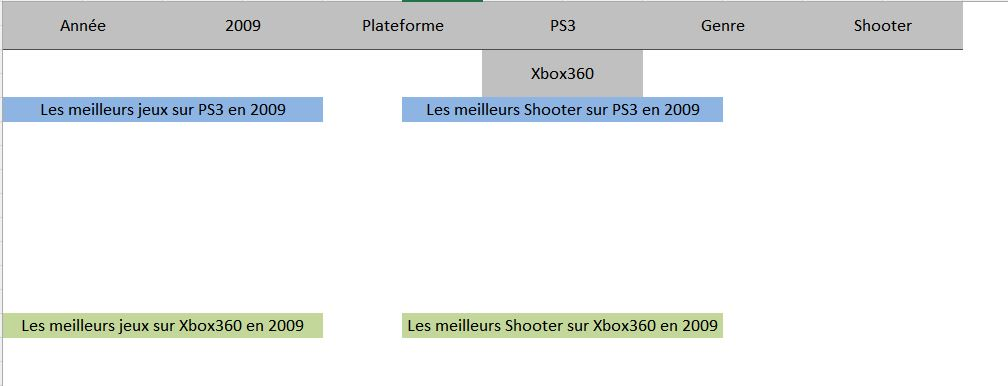

In [37]:
img = Image.open('../img/add_title_tdb.JPG')
img.show()

On peut maintenant passer à la création des en-têtes du tableaux (les noms de colonnes)

On va réutiliser la même méthode

In [38]:
def add_column_names_tdb(
        sheet: Worksheet,
        start_row: int,
        start_column: int,
        end_column: int,
        color: str
) -> None:
    """Ajouter les noms de colonnes pour les tableaux"""
    # Liste des noms de colonnes
    column_names = ['Nom', 'Ventes Totales', 'Ventes NA', 'Ventes EU']

    # Ajouter les noms de colonnes à la feuille
    for col_num, col_name in zip(range(start_column, end_column + 1), column_names):
        cell = sheet.cell(row=start_row, column=col_num)
        cell.value = col_name
        cell.fill = PatternFill(start_color=color, end_color=color, fill_type='solid')


In [39]:
wb = load_workbook(path_results)
TDB1_sheet = wb['TDB_1']

add_column_names_tdb(sheet=TDB1_sheet, start_row=6, start_column=1, end_column=4, color=light_blue)
add_column_names_tdb(sheet=TDB1_sheet, start_row=16, start_column=6, end_column=9, color=light_green)
add_column_names_tdb(sheet=TDB1_sheet, start_row=6, start_column=6,  end_column=9, color=light_blue)
add_column_names_tdb(sheet=TDB1_sheet, start_row=16, start_column=1, end_column=4, color=light_green)

wb.save(path_results)
wb.close()

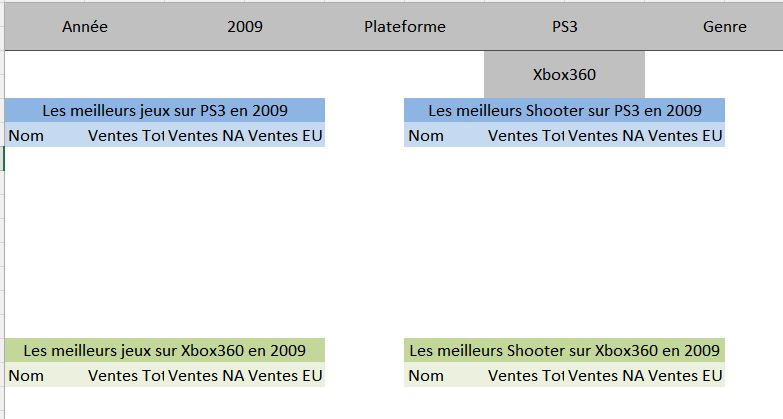

In [40]:
img = Image.open('../img/add_columns_names.JPG')
img.show()

In [41]:
def add_column_names(
        sheet: Worksheet,
        start_row: int,
        start_column: int,
        end_column: int,
        color: str
) -> None:
    """Ajouter les noms de colonnes pour les tableaux"""
    # Liste des noms de colonnes
    column_names = ['Nom', 'Ventes Totales', 'Ventes NA', 'Ventes EU']

    # Ajouter les noms de colonnes à la feuille
    for col_num, col_name in zip(range(start_column, end_column + 1), column_names):
        cell = sheet.cell(row=start_row, column=col_num)
        cell.value = col_name
        cell.fill = PatternFill(start_color=color, end_color=color, fill_type='solid')


On va maintenant faire une fonction qui permet d'alimenter les tableaux en data

Nous avons plusieurs options :
- Créer 16 fonctions qui contiennent la formule pour la colonne du tableau
- Créer 4 fonctions (1 par tableau)
- Créer 1 fonction qui s'adapte à chaque fois

J'opte pour la solution optimale une seule fonction (en réalité il y en 2)

In [42]:
def apply_formula(
    sheet: Worksheet, 
    cellule: str, 
    top: int, 
    platform: str, 
    target: str, 
    year: str='$C$1', 
    ref_sheet: str='cleaned_data', 
    genre=None
    ) -> None:
    """Apply formula to get data from the cleaned_data sheet"""
    if genre :
        formula = f"""
        =INDEX(
            {ref_sheet}!{target}:{target},
            MATCH(
                LARGE(
                    IF(
                        ({ref_sheet}!$C:$C={platform}) *
                        ({ref_sheet}!$D:$D={year}) *
                        ({ref_sheet}!$E:$E={genre}),
                        {ref_sheet}!$K:$K
                    ),
                    {top}
                ),
                IF(
                    ({ref_sheet}!$C:$C={platform}) *
                    ({ref_sheet}!$D:$D={year}) *
                    ({ref_sheet}!$E:$E={genre}),
                    {ref_sheet}!$K:$K
                ),
                0
            )
        )
"""
    else :
        formula = f"""
        =INDEX(
            {ref_sheet}!{target}:{target},
            MATCH(
                LARGE(
                    IF(
                        ({ref_sheet}!$C:$C={platform}) * 
                        ({ref_sheet}!$D:$D={year}),
                        {ref_sheet}!$K:$K
                    ),
                    {top}
                ),
                IF(
                    ({ref_sheet}!$C:$C={platform}) * 
                    ({ref_sheet}!$D:$D={year}),
                    {ref_sheet}!$K:$K
                ),
                0
            )
        )
        """
    sheet[cellule] = ArrayFormula(f"{cellule}:{cellule}", formula)


wb = load_workbook(path_results)
TDB1_sheet = wb['TDB_1']

# Premier tableau 
apply_formula(sheet=TDB1_sheet, cellule='A7', top=1, platform='$G$1', target='$B')
apply_formula(sheet=TDB1_sheet, cellule='A8', top=2, platform='$G$1',target='$B')
apply_formula(sheet=TDB1_sheet, cellule='A9', top=3, platform='$G$1',target='$B')
apply_formula(sheet=TDB1_sheet, cellule='A10', top=4, platform='$G$1',target='$B')
apply_formula(sheet=TDB1_sheet, cellule='A11', top=5, platform='$G$1',target='$B')

# Second tableau
apply_formula(sheet=TDB1_sheet, cellule='A17', top=1, platform='$G$3', target='$B')
apply_formula(sheet=TDB1_sheet, cellule='A18', top=2, platform='$G$3', target='$B')
apply_formula(sheet=TDB1_sheet, cellule='A19', top=3, platform='$G$3', target='$B')
apply_formula(sheet=TDB1_sheet, cellule='A20', top=4, platform='$G$3', target='$B')
apply_formula(sheet=TDB1_sheet, cellule='A21', top=5, platform='$G$3', target='$B')

# Troisième tableau
apply_formula(sheet=TDB1_sheet, cellule='F7', top=1, platform='$G$1', target='$B', genre='$K$1')
apply_formula(sheet=TDB1_sheet, cellule='F8', top=2, platform='$G$1', target='$B', genre='$K$1')
apply_formula(sheet=TDB1_sheet, cellule='F9', top=3, platform='$G$1', target='$B', genre='$K$1')
apply_formula(sheet=TDB1_sheet, cellule='F10', top=4, platform='$G$1', target='$B', genre='$K$1')
apply_formula(sheet=TDB1_sheet, cellule='F11', top=5, platform='$G$1', target='$B', genre='$K$1')

# Quatrième tableau
apply_formula(sheet=TDB1_sheet, cellule='F17', top=1, platform='$G$3', target='$B',  genre='$K$1')
apply_formula(sheet=TDB1_sheet, cellule='F18', top=2, platform='$G$3', target='$B', genre='$K$1')
apply_formula(sheet=TDB1_sheet, cellule='F19', top=3, platform='$G$3', target='$B', genre='$K$1')
apply_formula(sheet=TDB1_sheet, cellule='F20', top=4, platform='$G$3', target='$B', genre='$K$1')
apply_formula(sheet=TDB1_sheet, cellule='F21', top=5, platform='$G$3', target='$B', genre='$K$1')

wb.save(path_results)
wb.close()

Nous avons réussi à appliquer les formules sur les bonnes colonnes et le code fonctionne. 

Par contre, répéter X fois la formule n'est pas une bonne pratique, on va plutôt créer une fonction **apply_formulas** qui va boucler sur les cellules.
<br> On évitera ainsi de se répéter autant, d'autant plus que nous aurions dû les répéter pour chaque *target*

In [43]:
def apply_formulas(sheet: Worksheet, start_cell:tuple, top_values: list,targets: list, platform:str, genre:str=None):
   """Appliquer les formules correspondantes aux cellules."""
   for i, top in enumerate(top_values):
        print(f"\ni :{i}, top:{top}\n")
        for j, target in enumerate(targets):
            print(f"j :{j}, target:{target}")
            # Calculer la cellule cible en fonction de la colonne cible
            # chr(ord('A') + j) permet obtenir la lettre de la colonne suivante
            cellule = f"{chr(ord(start_cell[0]) + j)}{start_cell[1] + i}"
            print(cellule)
            if genre:
                apply_formula(sheet=sheet, cellule=cellule, top=top, target=target, platform=platform, genre=genre)
            else:
                apply_formula(sheet=sheet, cellule=cellule, top=top, target=target, platform=platform)


In [44]:
wb = load_workbook(path_results)
TDB1_sheet = wb['TDB_1']

# Appliquer la formule pour le premier tableau
apply_formulas(sheet=TDB1_sheet, start_cell=('A', 7), top_values=[1, 2, 3, 4, 5], targets=['B', 'K', 'G', 'H'], platform='$G$1')

# Second tableau
apply_formulas(sheet=TDB1_sheet, start_cell=('A', 17), top_values=[1, 2, 3, 4, 5], targets=['B', 'K', 'G', 'H'], platform='$G$3')

# Troisième tableau
apply_formulas(sheet=TDB1_sheet, start_cell=('F', 7), top_values=[1, 2, 3, 4, 5], targets=['B', 'K', 'G', 'H'], platform='$G$1', genre='$K$1')

# Quatrième tableau
apply_formulas(sheet=TDB1_sheet, start_cell=('F', 17), top_values=[1, 2, 3, 4, 5], targets=['B', 'K', 'G', 'H'], platform='$G$3', genre='$K$1')

wb.save(path_results)
wb.close()


i :0, top:1

j :0, target:B
A7
j :1, target:K
B7
j :2, target:G
C7
j :3, target:H
D7

i :1, top:2

j :0, target:B
A8
j :1, target:K
B8
j :2, target:G
C8
j :3, target:H
D8

i :2, top:3

j :0, target:B
A9
j :1, target:K
B9
j :2, target:G
C9
j :3, target:H
D9

i :3, top:4

j :0, target:B
A10
j :1, target:K
B10
j :2, target:G
C10
j :3, target:H
D10

i :4, top:5

j :0, target:B
A11
j :1, target:K
B11
j :2, target:G
C11
j :3, target:H
D11

i :0, top:1

j :0, target:B
A17
j :1, target:K
B17
j :2, target:G
C17
j :3, target:H
D17

i :1, top:2

j :0, target:B
A18
j :1, target:K
B18
j :2, target:G
C18
j :3, target:H
D18

i :2, top:3

j :0, target:B
A19
j :1, target:K
B19
j :2, target:G
C19
j :3, target:H
D19

i :3, top:4

j :0, target:B
A20
j :1, target:K
B20
j :2, target:G
C20
j :3, target:H
D20

i :4, top:5

j :0, target:B
A21
j :1, target:K
B21
j :2, target:G
C21
j :3, target:H
D21

i :0, top:1

j :0, target:B
F7
j :1, target:K
G7
j :2, target:G
H7
j :3, target:H
I7

i :1, top:2

j :0, target

Une solution plus simple à l'avenir: exploiter la capacité native d'Excel à faire *glisser* les formules, pour ça il faut convenablement ordonner les colonnes de **cleaned_data**  dès le départ

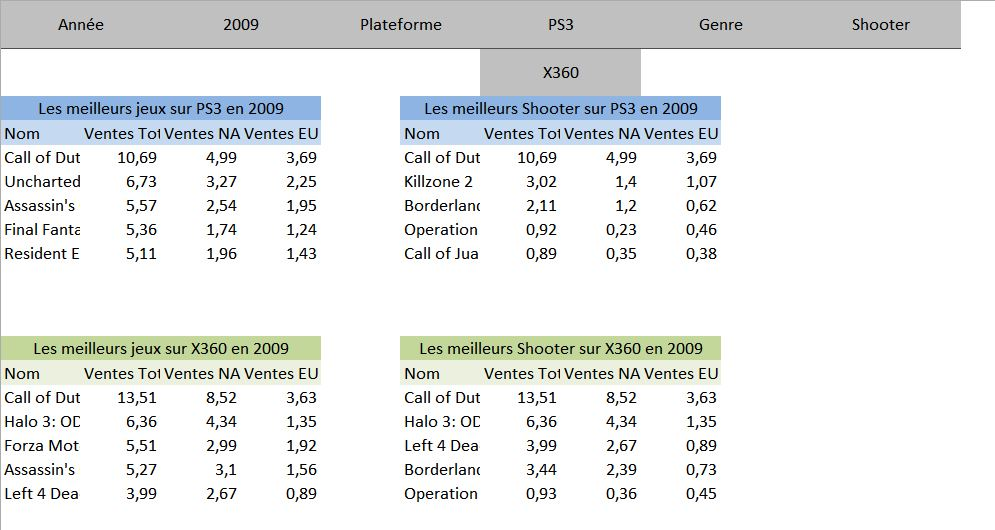

In [45]:
img = Image.open('../img/tops_5.JPG')
img.show()


#### 3. Création des graphiques

Nous allons à présent créer 2 graphiques en utilisant des *barcharts*.
<br>Les graphiques seront dynamiques en s'adaptant aux filtres puisqu'ils seront basés sur les tableaux précédents.

In [46]:
from openpyxl.chart import BarChart, Reference, Series

wb = load_workbook(path_results)

# Sélectionner l'onglet
TDB1_sheet = wb['TDB_1']

## Premier graph
chart_filter_1 = BarChart() # on initialise le graphique
chart_filter_1.type = "bar" # on chosit son type
chart_filter_1.style = 11 # on peut définir un style
chart_filter_1.title = "Top 5 des jeux vendus sur la plateforme " + TDB1_sheet['G1'].value
chart_filter_1.y_axis.title = 'Nb jeux vendus (en millions)'

data = Reference(TDB1_sheet, min_col=2, min_row=6, max_row=11, max_col=4) # Les valeurs
cats = Reference(TDB1_sheet, min_col=1, min_row=7, max_row=11) # Les titres

# Ajouter les données
chart_filter_1.add_data(data, titles_from_data=True)

#Légende
chart_filter_1.set_categories(cats)

#Ajouter le graph
TDB1_sheet.add_chart(chart_filter_1, "A23")
wb.save(path_results)
wb.close()

En fonction c'est toujours mieux 😎

In [47]:
from openpyxl.chart import BarChart, Reference, Series

def create_bar_chart(
    sheet: Worksheet, 
    chart_title: str, 
    data_range: dict, 
    category_range: dict, 
    chart_position: str, 
    style: int
) -> None:
    """Créer un graphique à barres."""
    # Initialiser le graphique
    chart = BarChart()
    chart.type = "bar"
    chart.style = style
    chart.title = chart_title
    chart.y_axis.title = 'Nb jeux vendus (en millions)'

    # Ajouter les données et les catégories
    data = Reference(sheet, min_col=data_range['min_col'], min_row=data_range['min_row'], max_row=data_range['max_row'], max_col=data_range['max_col'])
    cats = Reference(sheet, min_col=category_range['min_col'], min_row=category_range['min_row'], max_row=category_range['max_row'])

    chart.add_data(data, titles_from_data=True)
    chart.set_categories(cats)
 
    # Ajouter le graphique à la feuille
    sheet.add_chart(chart, chart_position)



Remarque : je n'insère pas délibérément les étiquettes de données, c'est assez compliqué à customiser avec openpyxl, je laisse donc la possibilité à l'utilisateur final de les rajouter par lui-même

```python
from openpyxl.chart.label import DataLabelList

series = chart.series[0]  # Sélectionner la première série de données
series.dLbls = DataLabelList()  # Créer une liste d'étiquettes de données
series.dLbls.showVal = True  # Afficher les valeurs des étiquettes de données  
```
Toutefois, si vous décidez de les insérer, voici le code ci-dessus. 
Vous pouvez boucler sur chart.series[i] pour ne pas avoir à les rajouter X fois.

In [48]:
wb = load_workbook(path_results)
TDB1_sheet = wb['TDB_1']

# Premier graphique
create_bar_chart(
    sheet=TDB1_sheet,
    chart_title="Top 5 des jeux vendus " + TDB1_sheet['G1'].value,
    data_range={'min_col': 2, 'min_row': 6, 'max_row': 11, 'max_col': 4},
    category_range={'min_col': 1, 'min_row': 7, 'max_row': 11},
    chart_position="A23",
    style=11
)

# Deuxième graphique
create_bar_chart(
    sheet=TDB1_sheet,
    chart_title="Top 5 des jeux vendus " + TDB1_sheet['G3'].value,
    data_range={'min_col': 2, 'min_row': 16, 'max_row': 21, 'max_col': 4},
    category_range={'min_col': 1, 'min_row': 17, 'max_row': 21},
    chart_position="F23",
    style=13
)

wb.save(path_results)
wb.close()

#### 4. Création des cartes 

In [49]:
wb = load_workbook(path_results)
TDB1_sheet = wb['TDB_1']

#cellules gauche haut
cell_title_1 = TDB1_sheet['L5']
cell_title_1.value  = f'="Nombre de jeux sortis sur " &G1 &" en " &C1'
TDB1_sheet.merge_cells(start_row=5, start_column=12, end_row=6, end_column=12)
cell_title_1.alignment  = Alignment(horizontal='center', vertical='center')
cell_title_1.fill = PatternFill(start_color=dark_blue, end_color=dark_blue, fill_type='solid')

cell_value_1 = TDB1_sheet['L7']
cell_value_1.value = f'=COUNTIFS(cleaned_data!$D:$D,$C$1,cleaned_data!$C:$C,$G$1)'
TDB1_sheet.merge_cells(start_row=7, start_column=12, end_row=8, end_column=12)
cell_value_1.alignment  = Alignment(horizontal='center', vertical='center')
cell_value_1.fill = PatternFill(start_color=light_blue, end_color=light_blue, fill_type='solid')
cell_value_1.font = Font(size=14)

wb.save(path_results)
wb.close()

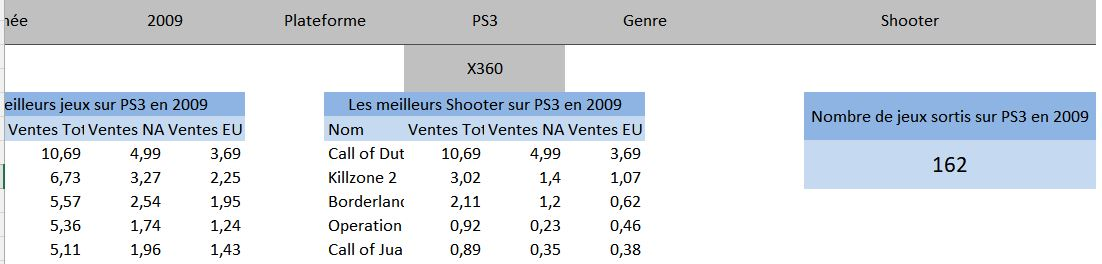

In [50]:
img = Image.open('../img/carte_indicator.JPG')
img.show()

ça ressemble à quelque chose qu'on a déjà fait non ?

On peut réutiliser la logique de la fonction **add_title_tdb**

In [51]:
def add_title_map(
        sheet: Worksheet,
        cell: str, 
        filter_platform: str, 
        color: str, 
        start_row: int, 
        start_column: int, 
        end_row: int, 
        end_column: int,
        type_value: str,
        filter_year: str = 'C1',
        filter_genre: str = None
) -> None:
    """Créer un titre dynamique pour les maps"""
    
    title_cell = sheet[cell]
    
    if filter_genre and type_value == 'count':
        formula = f'="Nombre de jeux de type " & {filter_genre} & " sur " & {filter_platform} & " en " & {filter_year}'
    elif filter_genre == '' and type_value == 'count':    
        formula = f'="Nombre de jeux sortis sur " & {filter_platform} & " en " & {filter_year}'
    elif filter_genre and type_value == 'sum':
        formula = f'="Nombre de jeux de type " & {filter_genre} & " vendus sur " & {filter_platform} & " en " & {filter_year}'
    elif filter_genre == '' and type_value == 'sum':    
        formula = f'="Nombre de jeux vendus sur " & {filter_platform} & " en " & {filter_year}'
    else:
        raise ValueError(f"Cas non géré : type_value={type_value}, filter_genre={filter_genre}")
    
    title_cell.value = formula
    title_cell.alignment  = Alignment(horizontal='center', vertical='center')
    title_cell.fill = PatternFill(start_color=color, end_color=color, fill_type='solid')
    TDB1_sheet.merge_cells(start_row=start_row, start_column=start_column, end_row=end_row, end_column=end_column)


In [52]:
wb = load_workbook(path_results)
TDB1_sheet = wb['TDB_1']

# On va définir une liste contenant les configurations de chaque titre
configs = [
    # (row, column, platform, color, genre, type_value)
    (5, 12, 'G1', dark_blue,'', 'count'),
    (5, 13, 'G1', dark_blue, 'K1', 'count'),
    (9, 12, 'G1', dark_blue, '', 'sum'),
    (9, 13, 'G1', dark_blue, 'K1', 'sum'),
    (15, 12, 'G3', dark_green,'', 'sum'),
    (15, 13, 'G3', dark_green, 'K1', 'sum'),
    (19, 12, 'G3', dark_green, '', 'sum'),
    (19, 13, 'G3', dark_green, 'K1', 'sum'),
]

for row, col, platform, color, genre, type_val in configs:
    col_letter = get_column_letter(col)
    cell = f'{col_letter}{row}'
    add_title_map(
        sheet=TDB1_sheet,
        cell=cell,
        filter_platform=platform,
        color=color,
        start_row=row,
        start_column=col,
        end_row=row+1,
        end_column=col,
        type_value = type_val,
        filter_genre=genre
    )
wb.save(path_results)
wb.close()

Maintenant il faut rajouter les formules qui récupèrent les données

In [53]:
def add_value_map(
        sheet: Worksheet,
        cell: str, 
        filter_platform: str, 
        color: str, 
        start_row: int, 
        start_column: int, 
        end_row: int, 
        end_column: int,
        type_value: str,
        filter_year: str = 'C1',
        filter_genre: str = None
) -> None:
    """Applique une formule dynamiquement pour les maps"""
    
    title_cell = sheet[cell]
    
    # Base de la formule
    base_formula = f'cleaned_data!$D:$D,{filter_year},cleaned_data!$C:$C,{filter_platform}'

    if type_value == 'count':
        if filter_genre:
            formula = f'=COUNTIFS({base_formula},cleaned_data!$E:$E,{filter_genre})'
        else:
            formula = f'=COUNTIFS({base_formula})'

    elif type_value == 'sum':
        sum_range = 'cleaned_data!$H:$H'
        if filter_genre:
            formula = f'=SUMIFS({sum_range}, {base_formula}, cleaned_data!$E:$E,{filter_genre}) & "M"'
        else:
            formula = f'=SUMIFS({sum_range}, {base_formula}) & "M"'
            
    else:
        raise ValueError(f"Cas non géré : type_value={type_value}, filter_genre={filter_genre}")
    
    title_cell.value = formula
    title_cell.alignment  = Alignment(horizontal='center', vertical='center')
    title_cell.fill = PatternFill(start_color=color, end_color=color, fill_type='solid')
    TDB1_sheet.merge_cells(start_row=start_row, start_column=start_column, end_row=end_row, end_column=end_column)


Pour vraiment bien faire les choses, cette fonction devrait être découpée en plus petits morceaux qui gèrent une responsabilité à la fois.

In [54]:
wb = load_workbook(path_results)
TDB1_sheet = wb['TDB_1']

# On va définir une liste contenant les configurations de chaque titre
configs = [
    # (row, column, platform, color, genre, type_val)
    (7, 12, 'G1', light_blue,'', 'count'),
    (7, 13, 'G1', light_blue, 'K1', 'count'),
    (11, 12, 'G1', light_blue, '', 'sum'),
    (11, 13, 'G1', light_blue, 'K1', 'sum'),
    (17, 12, 'G3', light_green,'', 'count'),
    (17, 13, 'G3', light_green, 'K1', 'count'),
    (21, 12, 'G3', light_green, '', 'sum'),
    (21, 13, 'G3', light_green, 'K1', 'sum'),
]

for row, col, platform, color, genre, type_val in configs:
    col_letter = get_column_letter(col)
    cell = f'{col_letter}{row}' # Exemple valeurs : L7, M7, L11, M11 etc.
    add_value_map(
        sheet=TDB1_sheet,
        cell=cell,
        filter_platform=platform,
        color=color,
        start_row=row,
        start_column=col,
        end_row=row+1,
        end_column=col,
        type_value=type_val,
        filter_genre=genre,
    )
    
wb.save(path_results)
wb.close()

> Remarque :
Le code des cellules suivantes est "brut", il n'a pas été *refactoré* 

#### 5. Ajuster la taille des colonnes

In [55]:
from openpyxl.utils import get_column_letter

wb = load_workbook(path_results)
sheet = wb['TDB_1']


for col in range(1, 10):
    column_letter = get_column_letter(col)
    for row in range(5, 22):
        cell = sheet[f"{column_letter}{row}"]
        if row == 5 or row == 15:
            cell.alignment = Alignment(horizontal='center', vertical='center', wrap_text=False)
        else : 
            cell.alignment = Alignment(horizontal='left', vertical='center', wrap_text=False)
    sheet.column_dimensions[column_letter].auto_size = True
    
for col in range(12, 15):
    column_letter = get_column_letter(col)
    sheet.column_dimensions[column_letter].auto_size = True

wb.save(path_results)
wb.close()

### V. Créer la feuille de calcul "calc_sheet"

In [ ]:
wb = load_workbook(path_results)

# Ajouter un onglet à la feuille de calcul si elle n'existe pas 
if 'calc_sheet' not in wb.sheetnames:
    # Créer la feuille
       calc_sheet = wb.create_sheet('calc_sheet')
else :
    calc_sheet = wb['calc_sheet']
    
####### Ajout des années ###############   
year_cell = calc_sheet['A1']
year_cell.value = f'Année'

for i in range(2, 40):
    cell = calc_sheet.cell(row=i, column=1)
    formule = f'=Ressources!B' + str(i)
    cell.value = formule


####### Ventes par année ############### 
tot_sales_cell_per_year = calc_sheet['B1']
tot_sales_cell_per_year.value = f'Ventes'

for i in range(2, 40):
    cell = calc_sheet.cell(row=i, column=2)
    formule = f'=SUMIFS(cleaned_data!K:K,cleaned_data!D:D,A'+str(i)+')'
    cell.value = formule

####### Nb jeux sortis par année ############### 
nb_jeux_per_year = calc_sheet['C1']
nb_jeux_per_year.value ='Nombre de jeux'

for i in range(2,40):
    cell = calc_sheet.cell(row=i, column=3)
    formule = f'=COUNTIFS(cleaned_data!B:B,"<>",cleaned_data!D:D,A'+str(i)+')'
    cell.value = formule

    
####### Ajout des genres ###############  
for i in range(1,14):
    cell = calc_sheet.cell(row=i, column=4)
    formule = f'=Ressources!C'+str(i)
    cell.value = formule
    
####### Nb jeux par genre ###############   
nb_jeux_per_genre = calc_sheet['E1']
nb_jeux_per_genre.value = 'Nombre de jeux'

for i in range(2,14):
    cell = calc_sheet.cell(row=i,column=5)
    formule = f'=COUNTIFS(cleaned_data!B:B,"<>",cleaned_data!E:E,D'+str(i)+')'
    cell.value = formule 

####### Ventes par genre ############### 
tot_sales_per_genre = calc_sheet['F1']
tot_sales_per_genre.value = 'Total ventes'

for i in range(2,14):
    cell = calc_sheet.cell(row=i,column=6)
    formule = f'=SUMIFS(cleaned_data!K:K,cleaned_data!E:E,D'+str(i)+')'
    cell.value = formule

editeur_title = calc_sheet['G1']
editeur_title.value = 'Editeurs'

####### Ajout des editeurs ###############
# Liste des éditeurs pré-définis 
values = ['Activision', 'Nintendo', 'Take-Two Interactive', 'Ubisoft', 'Square Enix', 'Electronic Arts']

for i, value in enumerate(values):
    cell = calc_sheet.cell(row=i+2, column=7)
    cell.value = value
    
####### Nb jeux sortis par édieurs ###############    
nb_jeux_per_publisher = calc_sheet['H1']
nb_jeux_per_publisher.value = 'Nombre de jeux'

for i in range(2,8):
    cell = calc_sheet.cell(row=i,column=8)
    formule = f'=COUNTIFS(cleaned_data!F:F,G'+str(i)+',cleaned_data!B:B,"<>")'
    cell.value = formule

####### Ventes par édieurs ###############
tot_sales_per_publisher = calc_sheet['I1']
tot_sales_per_publisher.value = 'Total ventes'

for i in range(2,8):
    cell = calc_sheet.cell(row=i,column=9)
    formule = f'=SUMIFS(cleaned_data!K:K,cleaned_data!F:F,G'+str(i)+')'
    cell.value = formule

wb.save(path_results)
wb.close()

### VI. Tableau de bord 2

In [57]:
from openpyxl.chart import LineChart,PieChart
wb = load_workbook(path_results)

# Ajouter un onglet à la feuille de calcul si elle n'existe pas 
if 'TDB_2' not in wb.sheetnames:
    # Créer la feuille
       TDB2_sheet = wb.create_sheet('TDB_2')
else :
    TDB2_sheet = wb['TDB_2']
    
calc_sheet = wb['calc_sheet']
TDB2_sheet.sheet_view.showGridLines = False 

## Premier graph Evolution du nombre de ventes de jeux par années 

chart1 = LineChart()
chart1.type = "Line Chart"
chart1.style = 11
chart1.title = "Evolution des ventes de jeux par année"
chart1.y_axis.title = 'Nb jeux vendus (en millions)'

#Les x
data = Reference(calc_sheet, min_col=2, min_row=1, max_row=39, max_col=2)
#Les y
cats = Reference(calc_sheet, min_col=1, min_row=2, max_row=39)

#Ajouter les données 
chart1.add_data(data, titles_from_data=True)
#Ajouter le graph
TDB2_sheet.add_chart(chart1, "A16")

wb.save(path_results)
wb.close()

In [58]:
wb = load_workbook(path_results)

#sheets
TDB2_sheet = wb['TDB_2']
calc_sheet = wb['calc_sheet']

# ------------------------------ #
##  Graph2 
chart2 = LineChart()
chart2.type = "Line Chart"
chart2.style = 11
chart2.title = "Evolution du nombre de jeux sortis par année"
chart2.y_axis.title = 'Nb jeux sortis'
data = Reference(calc_sheet, min_col=3, min_row=1, max_row=39, max_col=3)
cats = Reference(calc_sheet, min_col=1, min_row=2, max_row=39)
chart2.add_data(data, titles_from_data=True)
#Ajouter le graph
TDB2_sheet.add_chart(chart2, "A1")


# ------------------------------ #
## Graph3 
chart3 = BarChart()
chart3.type = "bar"
chart3.style = 11
chart3.title = "Nombre de jeux par genre"
chart3.y_axis.title = 'Nb jeux sortis'
data = Reference(calc_sheet, min_col=5, min_row=1, max_row=13, max_col=5)
cats = Reference(calc_sheet, min_col=4, min_row=2, max_row=13)
chart3.add_data(data, titles_from_data=True)


#Légende
chart3.set_categories(cats)


#Ajouter le graph
TDB2_sheet.add_chart(chart3, "J1")

# ------------------------------ #
## Graph4
chart4 = BarChart()
chart4.type = "bar"
chart4.style = 11
chart4.title = "Ventes tot. par genre"
chart4.y_axis.title = 'Nb jeux vendus (en millions)'
data = Reference(calc_sheet, min_col=6, min_row=1, max_row=13, max_col=6)
cats = Reference(calc_sheet, min_col=4, min_row=2, max_row=13)
chart4.add_data(data, titles_from_data=True)
#Ajouter le graph
TDB2_sheet.add_chart(chart4, "J16")


# ------------------------------ #
## Graph5
chart5 = PieChart()
#chart5.type = "bar"
#chart5.style = 11
chart5.title = "Nombre de jeux sortis par éditeur"
#chart5.y_axis.title = 'Nb jeux vendus (en millions)'
data = Reference(calc_sheet, min_col=8, min_row=1, max_row=7, max_col=8)
cats = Reference(calc_sheet, min_col=7, min_row=2, max_row=7)
chart5.add_data(data, titles_from_data=True)

# Ajouter des étiquettes de données
chart5.dataLabels = DataLabelList()
chart5.dataLabels.showPercent = True
chart5.dataLabels.showVal = False


#Ajouter le graph
TDB2_sheet.add_chart(chart5, "S1")

# ------------------------------ #
## Graph6
chart6 = PieChart()
#chart6.type = "Line Chart"
chart6.title = "Nombre de jeux vendus par éditeur"
#chart6.y_axis.title = 'Nb jeux vendus (en millions)'
data = Reference(calc_sheet, min_col=9, min_row=1, max_row=7, max_col=9)
cats = Reference(calc_sheet, min_col=7, min_row=2, max_row=7)
chart6.add_data(data, titles_from_data=True)

# Ajouter des étiquettes de données
chart6.dataLabels = DataLabelList()
chart6.dataLabels.showPercent = True
chart6.dataLabels.showVal = False

#Légende
chart6.set_categories(cats)

#Ajouter le graph
TDB2_sheet.add_chart(chart6, "S16")


wb.save(path_results)
wb.close()